In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install tensorflow-addons

In [ ]:
import keras
from keras.layers import LSTM, Dropout, Dense
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers
from tensorflow.keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from keras.models import Model
from tensorflow.keras.utils import get_custom_objects
from keras.layers import Activation
from keras.backend import sigmoid
import keras.backend as K

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

np.random.seed(1992)
tf.keras.utils.set_random_seed(1992)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
df_Confirmed = pd.read_csv('/content/drive/MyDrive/AI Projects/Covid19forcasting(TransferULMfit)_ver2/Data/Preparing_time_series_covid19_confirmed_global.csv')
df_Deaths = pd.read_csv('/content/drive/MyDrive/AI Projects/Covid19forcasting(TransferULMfit)_ver2/Data/Preparing_time_series_covid19_deaths_global.csv')

In [ ]:
Country = 'Thailand'
df_Confirmed = df_Confirmed[df_Confirmed['Country/Region']==Country].drop(columns = "Country/Region")
df_Deaths = df_Deaths[df_Deaths['Country/Region']==Country].drop(columns = "Country/Region")

In [ ]:
df_Confirmed

,1/22/2020,1/23/2020,1/24/2020,1/25/2020,1/26/2020,1/27/2020,1/28/2020,1/29/2020,1/30/2020,1/31/2020,...,2/28/2023,3/1/2023,3/2/2023,3/3/2023,3/4/2023,3/5/2023,3/6/2023,3/7/2023,3/8/2023,3/9/2023
177,4,4,5,6,8,8,14,14,14,19,...,4728035,4728035,4728035,4728035,4728035,4728182,4728182,4728182,4728182,4728182


In [ ]:
df_Deaths

,1/22/2020,1/23/2020,1/24/2020,1/25/2020,1/26/2020,1/27/2020,1/28/2020,1/29/2020,1/30/2020,1/31/2020,...,2/28/2023,3/1/2023,3/2/2023,3/3/2023,3/4/2023,3/5/2023,3/6/2023,3/7/2023,3/8/2023,3/9/2023
177,0,0,0,0,0,0,0,0,0,0,...,33911,33911,33911,33911,33911,33918,33918,33918,33918,33918


In [ ]:
df_Confirmed = df_Confirmed.T
df_Confirmed.columns = ["Confirmed"]
df_Confirmed_train = df_Confirmed.iloc[:-30]
df_Confirmed_test = df_Confirmed.iloc[-45:]

df_Deaths = df_Deaths.T
df_Deaths.columns = ["Deaths"]
df_Deaths_train = df_Deaths.iloc[:-30]
df_Deaths_test = df_Deaths.iloc[-45:]

<Axes: >

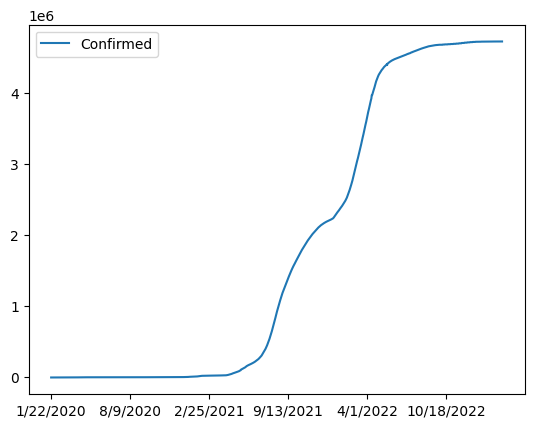

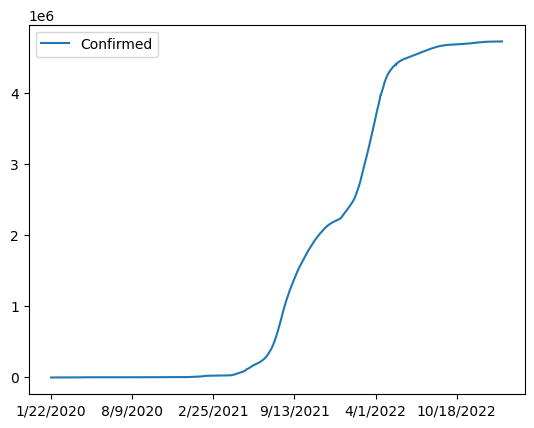

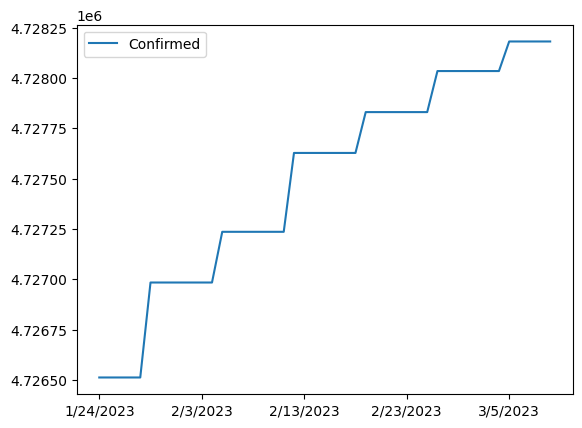

In [ ]:
df_Confirmed.plot( kind='line')
df_Confirmed_train.plot( kind='line')
df_Confirmed_test.plot( kind='line')

In [ ]:
df_Confirmed_train

,Confirmed
1/22/2020,4
1/23/2020,4
1/24/2020,5
1/25/2020,6
1/26/2020,8
...,...
2/3/2023,4726984
2/4/2023,4726984
2/5/2023,4727236
2/6/2023,4727236


In [ ]:
df_Confirmed_test

,Confirmed
1/24/2023,4726512
1/25/2023,4726512
1/26/2023,4726512
1/27/2023,4726512
1/28/2023,4726512
1/29/2023,4726984
1/30/2023,4726984
1/31/2023,4726984
2/1/2023,4726984
2/2/2023,4726984


In [ ]:
data = pd.concat([df_Confirmed_train,df_Deaths_train], axis=1)
data

,Confirmed,Deaths
1/22/2020,4,0
1/23/2020,4,0
1/24/2020,5,0
1/25/2020,6,0
1/26/2020,8,0
...,...,...
2/3/2023,4726984,33865
2/4/2023,4726984,33865
2/5/2023,4727236,33882
2/6/2023,4727236,33882


In [ ]:
def MinMaxScale(df):
  df_norm = pd.DataFrame([])
  min = []
  max = []
  MinMaxScaleColumnName = []
  for c in df.columns:
    new_df = (df[[c]]-df[[c]].min())/(df[[c]].max()-df[[c]].min())
    min.append(df[[c]].min())
    max.append(df[[c]].max())
    MinMaxScaleColumnName.append(c)
    df_norm = pd.concat([df_norm,new_df], axis=1)
  return df_norm,min,max

In [ ]:
data,minScale,maxScale= MinMaxScale(data)
data

,Confirmed,Deaths
1/22/2020,0.000000e+00,0.000000
1/23/2020,0.000000e+00,0.000000
1/24/2020,2.115403e-07,0.000000
1/25/2020,4.230806e-07,0.000000
1/26/2020,8.461611e-07,0.000000
...,...,...
2/3/2023,9.999467e-01,0.999498
2/4/2023,9.999467e-01,0.999498
2/5/2023,1.000000e+00,1.000000
2/6/2023,1.000000e+00,1.000000


In [ ]:
minScale,maxScale

([Confirmed    4
  dtype: int64,
  Deaths    0
  dtype: int64],
 [Confirmed    4727236
  dtype: int64,
  Deaths    33882
  dtype: int64])

In [ ]:
data_test = pd.concat([df_Confirmed_test,df_Deaths_test], axis=1)
data_test

,Confirmed,Deaths
1/24/2023,4726512,33836
1/25/2023,4726512,33836
1/26/2023,4726512,33836
1/27/2023,4726512,33836
1/28/2023,4726512,33836
1/29/2023,4726984,33865
1/30/2023,4726984,33865
1/31/2023,4726984,33865
2/1/2023,4726984,33865
2/2/2023,4726984,33865


In [ ]:
def MinMaxScaleForTest(df,minScale,maxScale):
  df_norm = pd.DataFrame([])
  min = []
  max = []
  MinMaxScaleColumnName = []
  for i,c in enumerate(df.columns):
    new_df = (df[[c]]-minScale[i][c])/(maxScale[i][c]-minScale[i][c])
    # new_df = (df[[c]]-minScale[i][c])/(maxScale[i][c])
    # print(c)
    # print(new_df)

    df_norm = pd.concat([df_norm,new_df], axis=1)

  return df_norm

In [ ]:
data_test = MinMaxScaleForTest(data_test,minScale,maxScale)
data_test

,Confirmed,Deaths
1/24/2023,0.999847,0.998642
1/25/2023,0.999847,0.998642
1/26/2023,0.999847,0.998642
1/27/2023,0.999847,0.998642
1/28/2023,0.999847,0.998642
1/29/2023,0.999947,0.999498
1/30/2023,0.999947,0.999498
1/31/2023,0.999947,0.999498
2/1/2023,0.999947,0.999498
2/2/2023,0.999947,0.999498


In [ ]:
len(data_test.loc[:, "Confirmed"])

45

In [ ]:
sequence_length = 14
def generate_data(X, sequence_length = 14, step = 1):
    X_local = []
    y_local = []
    for start in range(0, len(X) - sequence_length-1, step):
        end = start + sequence_length
        # print(start,end)
        print(start,"X:",X[start:end],"| y:",X[end][0])
        X_local.append(X[start:end])
        y_local.append(X[end][0])
    return np.array(X_local), np.array(y_local)



In [ ]:
X_sequence,y = generate_data(data.loc[:, ["Confirmed"]].values)

In [ ]:
X_sequence_test,y_test = generate_data(data_test.loc[:, ["Confirmed"]].values)

In [ ]:
X_sequence.shape,y.shape

((1098, 14, 1), (1098,))

In [ ]:
X_sequence_test.shape,y_test.shape

((30, 14, 1), (30,))

In [ ]:
from sklearn.utils import shuffle
X_sequence, y = shuffle(X_sequence, y, random_state=0)
X_sequence.shape,y.shape

((1098, 14, 1), (1098,))

In [ ]:
DataX_train, y_train = X_sequence, y
DataX_valid, y_valid = X_sequence_test,y_test

print(DataX_train.shape,DataX_valid.shape)
print(y_train.shape,y_test.shape)

(1098, 14, 1) (30, 14, 1)
(1098,) (30,)


#Load Pre-Trained model

In [ ]:
def swish(x, beta = 0.5):
    return (x * sigmoid(beta * x))

get_custom_objects().update({'swish': Activation(swish)})

In [ ]:
dropout_rate=0.4

input1 = keras.Input(shape=(14,1),name="FirstPattern")
x1 = layers.LSTM(50,
                return_sequences=True,
                activation="swish",
                name="LSTML1",)(input1)
x1 = Dropout(dropout_rate, name='LSTM1_dropout')(x1)
x1 = layers.LSTM(50,
                return_sequences=True,
                activation="swish",
                name="LSTM2",)(x1)
x1 = Dropout(dropout_rate, name='LSTML2_dropout')(x1)
x1 = layers.LSTM(50,
                return_sequences=False,
                activation="swish",
                name="LSTML3",)(x1)
# x1 = Dropout(dropout_rate, name='LSTML3_dropout')(x1)

input2 = keras.Input(shape=(14,1),name="SecondPattern")
x2 = layers.LSTM(50,
                return_sequences=True,
                activation="swish",
                name="LSTMR1")(input2)
x2 = Dropout(dropout_rate, name='LSTMR1_dropout')(x2)
x2 = layers.LSTM(50,
                return_sequences=True,
                activation="swish",
                name="LSTMR2")(x2)
x2 = Dropout(dropout_rate, name='LSTMR2_dropout')(x2)
x2 = layers.LSTM(50,
                return_sequences=False,
                activation="swish",
                name="LSTMR3")(x2)
# x2 = Dropout(dropout_rate, name='LSTMR3_dropout')(x2)

x = layers.Concatenate(axis=1)([x1,x2])
x = Dense(16, activation='swish',name="Dense")(x)
x = Dropout(dropout_rate, name='dense_dropout')(x)
output = Dense(1, activation='sigmoid',name="Predict")(x)

PreTrained_model = keras.Model(inputs=[input1,input2], outputs=output)
PreTrained_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 FirstPattern (InputLayer)   [(None, 14, 1)]              0         []                            
                                                                                                  
 SecondPattern (InputLayer)  [(None, 14, 1)]              0         []                            
                                                                                                  
 LSTML1 (LSTM)               (None, 14, 50)               10400     ['FirstPattern[0][0]']        
                                                                                                  
 LSTMR1 (LSTM)               (None, 14, 50)               10400     ['SecondPattern[0][0]']       
                                                                                              

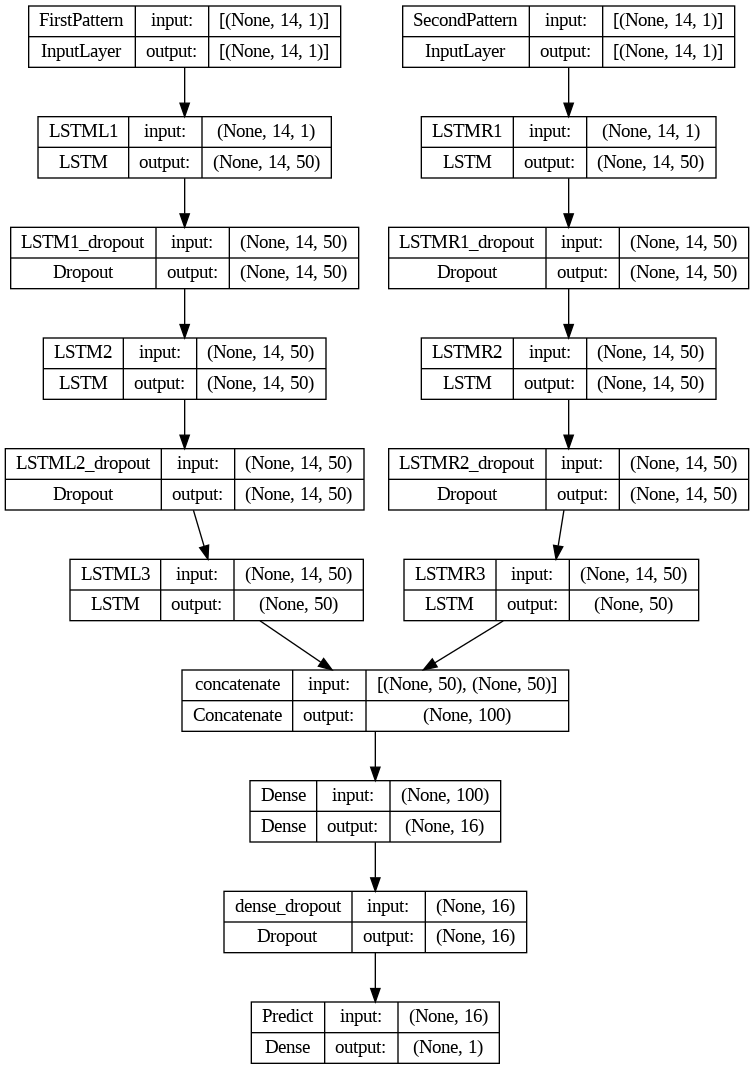

In [ ]:
PreTrained_path = '/content/drive/MyDrive/AI Projects/Covid19forcasting(TransferULMfit)_ver2/Experiments/Pre-trained model/Model/Weight_LSTM_PretrainedModel(Confirmed).h5'
PreTrained_model.load_weights(PreTrained_path)
keras.utils.plot_model(PreTrained_model, "PreTrained_model.png", show_shapes=True)

In [ ]:
base_model = keras.Model(inputs=PreTrained_model.get_layer('LSTML1').input,
                         outputs=PreTrained_model.get_layer('LSTML3').output,
                         name="BasedLSTM")

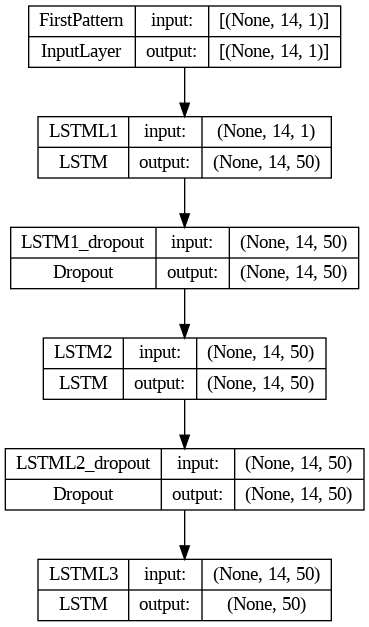

In [ ]:
keras.utils.plot_model(base_model, "base_model.png", show_shapes=True)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 FirstPattern (InputLayer)   [(None, 14, 1)]           0         
                                                                 
 LSTML1 (LSTM)               (None, 14, 50)            10400     
                                                                 
 LSTM1_dropout (Dropout)     (None, 14, 50)            0         
                                                                 
 LSTM2 (LSTM)                (None, 14, 50)            20200     
                                                                 
 LSTML2_dropout (Dropout)    (None, 14, 50)            0         
                                                                 
 LSTML3 (LSTM)               (None, 50)                20200     
                                                                 
 Predict (Dense)             (None, 1)                 51  

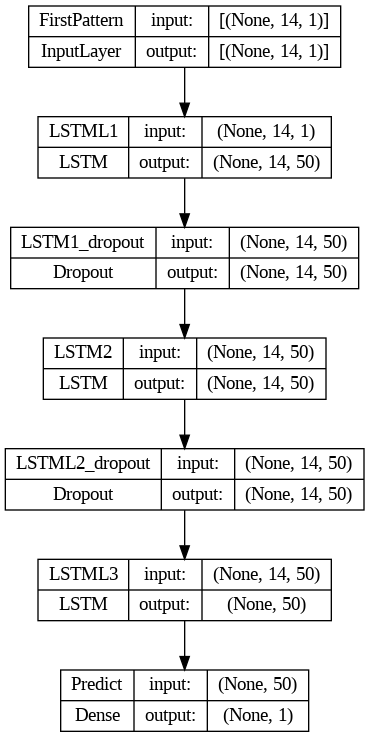

In [ ]:
# output = Dropout(0.4,name="Dropout")(base_model.output)
output = Dense(1, activation='linear',name="Predict")(base_model.output)
Final_model= keras.Model(inputs=base_model.input, outputs=output)
Final_model.summary()
keras.utils.plot_model(Final_model, "Final_model.png", show_shapes=True)

# Training Phase

In [ ]:
list_loss_train = []
list_loss_val = []
list_lr = []

BatchSize = 128
StartEpochs = 30
Epochs = 200

In [ ]:
model_path = f"/content/drive/MyDrive/AI Projects/Covid19forcasting(TransferULMfit)_ver2/Experiments/ForecatingModel/Confirmed/Standard/Models/{Country}_Weight_FineTune_LSTM_Baseline(Confirmed).h5"
opt = keras.optimizers.Adam(learning_rate=1e-2)

In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Metric to monitor
    factor=0.5,          # Factor by which the learning rate will be reduced
    patience=15,          # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-15,         # Lower bound on the learning rate
    verbose=1            # Verbosity mode
)

In [ ]:
def lr_schedule(epoch, initial_lr=0.01, warmup_epochs=30, warmup_factor=0.5):
    if epoch < warmup_epochs:
        return initial_lr * (warmup_factor + (1 - warmup_factor) * epoch / warmup_epochs)
    return initial_lr

lr_scheduler = LearningRateScheduler(lambda epoch: lr_schedule(epoch))

In [ ]:
checkpoint = ModelCheckpoint(
    filepath=model_path,
    save_best_only=True,
    save_weights_only=True,
    monitor='val_loss',mode='min',
    save_freq="epoch")

# early_stop = EarlyStopping(
#     monitor='val_loss',
#     min_delta=0.001,
#     patience=50,
#     mode='min')

In [ ]:
class LearningRateLogger(Callback):
    def __init__(self):
        super().__init__()
        self.learning_rates = []

    def on_epoch_begin(self, epoch, logs=None):
        lr = self.model.optimizer.learning_rate  # Get the current learning rate
        self.learning_rates.append(lr)
        print(f'Epoch {epoch + 1}: Learning Rate = {lr.numpy()}')

lr_logger = LearningRateLogger()


In [ ]:
Final_model.compile(loss='mean_squared_error',
                    optimizer=opt)
Final_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 FirstPattern (InputLayer)   [(None, 14, 1)]           0         
                                                                 
 LSTML1 (LSTM)               (None, 14, 50)            10400     
                                                                 
 LSTM1_dropout (Dropout)     (None, 14, 50)            0         
                                                                 
 LSTM2 (LSTM)                (None, 14, 50)            20200     
                                                                 
 LSTML2_dropout (Dropout)    (None, 14, 50)            0         
                                                                 
 LSTML3 (LSTM)               (None, 50)                20200     
                                                                 
 Predict (Dense)             (None, 1)                 51  

In [ ]:
hist = Final_model.fit(DataX_train,
          y_train,
          # validation_data=(DataX_valid,y_valid),
          validation_split=0.2,
          batch_size=BatchSize,
          epochs=StartEpochs,
          callbacks=[checkpoint,
                     lr_scheduler,
                     lr_logger,
                     ],
                 shuffle = True)


Epoch 1: Learning Rate = 0.004999999888241291
Epoch 1/30
7/7 [==============================] - 8s 362ms/step - loss: 78.2758 - val_loss: 3.9208 - lr: 0.0050
Epoch 2: Learning Rate = 0.005166666582226753
Epoch 2/30
7/7 [==============================] - 1s 97ms/step - loss: 1.2366 - val_loss: 0.0387 - lr: 0.0052
Epoch 3: Learning Rate = 0.005333333276212215
Epoch 3/30
7/7 [==============================] - 1s 98ms/step - loss: 0.0726 - val_loss: 0.0667 - lr: 0.0053
Epoch 4: Learning Rate = 0.005499999970197678
Epoch 4/30
7/7 [==============================] - 1s 106ms/step - loss: 0.0476 - val_loss: 0.0321 - lr: 0.0055
Epoch 5: Learning Rate = 0.00566666666418314
Epoch 5/30
7/7 [==============================] - 1s 129ms/step - loss: 0.0301 - val_loss: 0.0243 - lr: 0.0057
Epoch 6: Learning Rate = 0.005833333358168602
Epoch 6/30
7/7 [==============================] - 1s 192ms/step - loss: 0.0195 - val_loss: 0.0131 - lr: 0.0058
Epoch 7: Learning Rate = 0.006000000052154064
Epoch 7/30
7/7

In [ ]:
list_loss_train = list_loss_train + hist.history['loss']
list_loss_val = list_loss_val + hist.history['val_loss']
list_lr = list_lr + hist.history['lr']

In [ ]:
opt = keras.optimizers.Adam(learning_rate=1e-3)
Final_model.compile(loss='mean_squared_error',
                    optimizer=opt)

hist = Final_model.fit(DataX_train,
          y_train,
          # validation_data=(DataX_valid,y_valid),
          validation_split=0.2,
          batch_size=BatchSize,
          epochs=Epochs,
          callbacks=[checkpoint,
                     reduce_lr,
                     lr_logger,
                     ],
                 shuffle = True)

Epoch 1: Learning Rate = 0.0010000000474974513
Epoch 1/200
7/7 [==============================] - 6s 140ms/step - loss: 0.0010 - val_loss: 3.2886e-04 - lr: 0.0010
Epoch 2: Learning Rate = 0.0010000000474974513
Epoch 2/200
7/7 [==============================] - 0s 54ms/step - loss: 8.5753e-04 - val_loss: 1.8135e-04 - lr: 0.0010
Epoch 3: Learning Rate = 0.0010000000474974513
Epoch 3/200
7/7 [==============================] - 0s 47ms/step - loss: 6.9574e-04 - val_loss: 2.4189e-04 - lr: 0.0010
Epoch 4: Learning Rate = 0.0010000000474974513
Epoch 4/200
7/7 [==============================] - 0s 47ms/step - loss: 5.2716e-04 - val_loss: 2.0700e-04 - lr: 0.0010
Epoch 5: Learning Rate = 0.0010000000474974513
Epoch 5/200
7/7 [==============================] - 0s 69ms/step - loss: 4.9898e-04 - val_loss: 1.9632e-04 - lr: 0.0010
Epoch 6: Learning Rate = 0.0010000000474974513
Epoch 6/200
7/7 [==============================] - 1s 85ms/step - loss: 5.5091e-04 - val_loss: 1.0514e-04 - lr: 0.0010
Epoch 7

In [ ]:
list_loss_train = list_loss_train + hist.history['loss']
list_loss_val = list_loss_val + hist.history['val_loss']
list_lr = list_lr + hist.history['lr']

In [ ]:
np.array(list_loss_train)

In [ ]:
np.array(list_loss_val)

In [ ]:
np.array(list_lr)

In [ ]:
input = keras.Input(shape=(14,1))
x = layers.LSTM(50,return_sequences=True,activation="swish")(input)
x = Dropout(0.4)(x)
x = layers.LSTM(50,return_sequences=True,activation="swish")(x)
x = Dropout(0.4)(x)
x = layers.LSTM(50,return_sequences=False,activation="swish")(x)
output = Dense(1, activation='linear')(x)
model= Model(inputs=input, outputs=output)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 14, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 14, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 14, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 14, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 14, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51  

In [ ]:
model.load_weights(model_path)

In [ ]:
history = {"loss":list_loss_train,
           'val_loss':list_loss_val,
           'lr':list_lr}

Text(0, 0.5, 'loss')

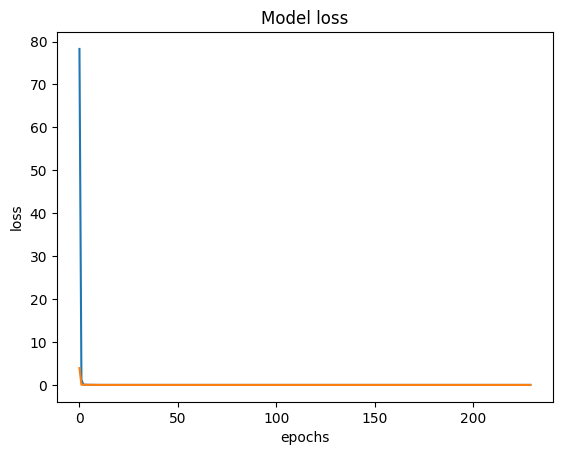

In [ ]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.xlabel('epochs')
plt.ylabel('loss')

Text(0, 0.5, 'lr')

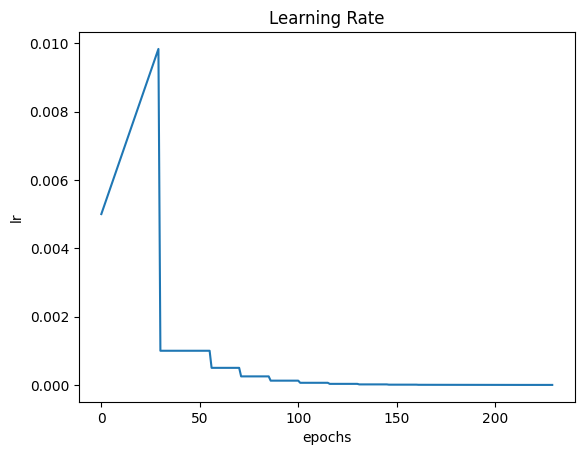

In [ ]:
plt.plot(history['lr'])
plt.title('Learning Rate')
plt.xlabel('epochs')
plt.ylabel('lr')

In [ ]:
X_sequence_test

In [ ]:
X_sequence_test_Zero = np.zeros_like(X_sequence_test)

In [ ]:
y_pred = Final_model.predict(X_sequence_test)
y_pred = y_pred.flatten()

1/1 [==============================] - 0s 497ms/step


In [ ]:
y_pred

In [ ]:
def MinMaxScaleInverse(y,minScale,maxScale,col,c):
  y = y*(maxScale[c][c]-minScale[c][col])+minScale[c][col]
  return y

In [ ]:
y_pred = MinMaxScaleInverse(y_pred,minScale,maxScale,"Confirmed",0)
y_test = MinMaxScaleInverse(y_test,minScale,maxScale,"Confirmed",0)
print(y_pred)
print(y_test)

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras import backend as K
import math

def S_mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) /((np.abs(y_true)+np.abs(y_pred))/2))) * 100

def mean_absolute_percentage_error(y_true, y_pred):
  diff = K.abs((y_true - y_pred) / K.clip(K.abs(y_true), K.epsilon(),None))
  return 100. * K.mean(diff, axis=-1)

def root_mean_squared_log_error(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return (np.mean((np.log(y_true)-np.log(y_pred))**2))**(1/2)

def explained_variance(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return 1-(np.var(y_pred-y_true)/np.var(y_true))

In [ ]:
print("***************************Results of testing****************************")

testScore_RMSE = math.sqrt(mean_squared_error(y_test, y_pred))
print('Test Score: %.5f RMSE' % (testScore_RMSE))

testScore_MAE = mean_absolute_error(y_test, y_pred)
print('Test Score: %.5f MAE' % (testScore_MAE))

testScore_MAPE = mean_absolute_percentage_error(y_test, y_pred)
print('Test Score: %.5f MAPE' % (testScore_MAPE))

testScore_SMAPE = S_mean_absolute_percentage_error(y_test, y_pred)
print('Test Score: %.5f SMAPE' % (testScore_SMAPE))

testScore_RMSLE = root_mean_squared_log_error(y_test, y_pred)
print('Test Score: %.5f RMSLE' % (testScore_RMSLE))

testScore_EV = explained_variance(y_test, y_pred)
print('Test Score: %.5f EV' % (testScore_EV))

***************************Results of testing****************************
Test Score: 23032.96338 RMSE
Test Score: 23032.63390 MAE
Test Score: 0.48718 MAPE
Test Score: 0.48837 SMAPE
Test Score: 0.00488 RMSLE
Test Score: 0.83509 EV


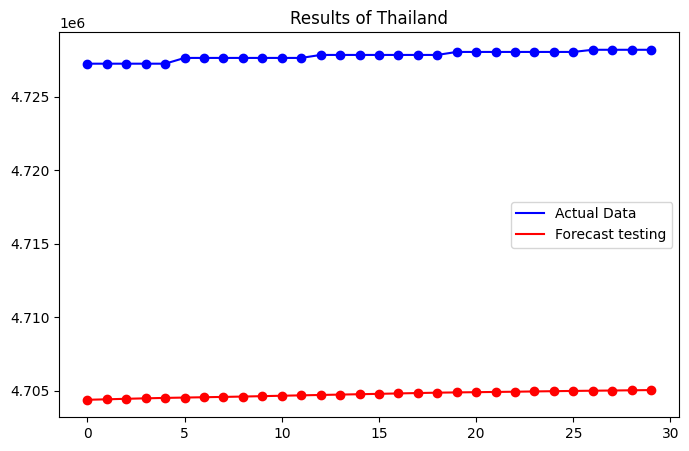

In [ ]:
plt.figure(figsize = (8,5))
#plt.title('Results of'.format(Beta[2]))
#plt.figure(figsize=(18,12))
plt.plot(y_test,label="Actual Data",color='b')
plt.plot(y_test,'bo')
plt.plot(y_pred,label="Forecast testing",color='r')
plt.plot(y_pred,'ro')
plt.legend()
plt.title('Results of {}'.format(Country))
plt.show()